In [2]:
import numpy as np
import math

from random import sample, shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.animation import FuncAnimation

from itertools import islice

In [19]:
def visualize_data(X, file_name):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1],c='r',s=10)
    plt.xticks(np.arange(min(X[:,0]), max(X[:,0])+1, 1))
    plt.yticks(np.arange(min(X[:,1]), max(X[:,1])+1, 2))
    plt.plot(X[:,0], X[:,1], "b-")
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xticks(np.arange(min(X[:,0]), max(X[:,0])+1, 1))
    plt.yticks(np.arange(min(X[:,1]), max(X[:,1])+1, 2))
    
    plt.title("Travelling Salesman Problem")
    plt.savefig(file_name)
    plt.show()


In [5]:
start_line = 7 
with open ('ulysses22.tsp') as f:
    lines = []
    for line in islice(f, start_line, 29):
        _, x1, x2 = line.split()
        lines.append([x1,x2])
    cities = np.asarray(lines,dtype=np.float32) 
cities.shape  

(22, 2)

In [4]:
start_line = 6 
with open ('eil51.tsp') as f:
    lines = []
    for line in islice(f, start_line, 57):
        _, x1, x2 = line.split()
        lines.append([x1,x2])
    cities = np.asarray(lines,dtype=np.float32) 
    

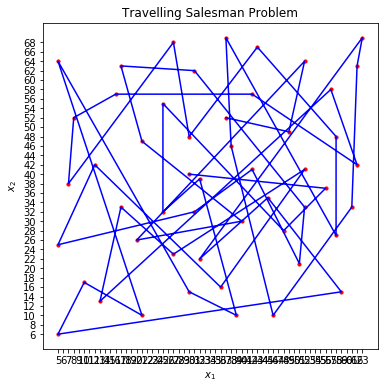

In [6]:
visualize_data(cities)

In [6]:
# create input data for the problem: cities, distances and population


import numpy as np
import math

from random import sample, shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances


from itertools import islice

start_line = 7 
with open ('ulysses22.tsp') as f:
    lines = []
    for line in islice(f, start_line, 29):
        _, x1, x2 = line.split()
        lines.append([x1,x2])
    cities = np.asarray(lines,dtype=np.float32)

start_line = 6
with open('eil51.tsp') as f:
    lines = []
    for line in islice(f, start_line, 57):
        _, x1, x2 = line.split()
        lines.append([x1, x2])
    cities = np.asarray(lines, dtype=np.float32)



class GeneticAlgo():
    def __init__(self,genes):
        self.n_genes = genes.shape[0]
        self.distances =  pairwise_distances(genes, metric='euclidean')
    
    def init_population(self,n_chromosomes:int):
        """
        Generate a population of n_chromosomes consisting of different permutations of n_genes.
        """
        self.n_chromosomes = n_chromosomes
        population = []
        n = 0
        while n < self.n_chromosomes:
            chromosome = np.random.permutation(self.n_genes)
            if not any([np.array_equal(self.n_chromosomes, x) for x in population]):
                population.append(chromosome)
                n += 1

        self.population = population

    def fitness(self,chromosome:list):
        """
        Sum distances between cities by the order of genes in THAT chromosome.
        """

        fitness = 0
        for i in range(len(chromosome) - 1):
            fitness += self.distances[chromosome[i]][chromosome[i+1]]
        return fitness

    
    def tournament_selection(self,selection_factor, k=2, p=0):
        """
        Select k random chromosomes, keep the best one (highest ﬁtness) and iterate for n=selection_factor times.
        If p != 0 and k == 2 then stochastic tournament selection is applied with probability p of getting the best chromosome.
        """

        new_population = []

        if p != 0 and k == 2:
            for i in range(selection_factor):
                s = sample(self.population, k)
                if np.random.rand() < p:
                    new_population.append(min([[x, fitness(x)] for x in s], key=lambda x: x[1])[0])
                else:
                    new_population.append(max([[x, fitness(x)] for x in s], key=lambda x: x[1])[0])
        else:
            for i in range(selection_factor):
                s = sample(self.population, k)
                new_population.append(min([[x, self.fitness(x)] for x in s], key=lambda x: x[1])[0])

        return new_population    

    

    def mutation(self,chromosome:list):
        """
        Switch two random genes of the chromosome.
        """

        mutated = np.array(chromosome)
        gene1, gene2 = sample(range(len(chromosome)), 2)
        mutated[gene1] = chromosome[gene2]
        mutated[gene2] = chromosome[gene1]
        return mutated    
    

    def _two_point_crossover(self,parent1, parent2):
        """
        Produces offsprings of parent1 and parent2 by using two points crossover.
        """
        n_genes = len(parent1)


        cross_point1, cross_point2 = np.random.choice(n_genes,2)

        sample(range(n_genes), 2)
        if (cross_point1 > cross_point2):
            tmp = cross_point1
            cross_point1 = cross_point2
            cross_point2 = tmp

        child1 = np.array(parent1)
        child2 = np.array(parent2)
        j1 = cross_point1
        j2 = cross_point2
        for i in range(cross_point1, cross_point2):
            while parent2[j1] not in parent1[cross_point1:cross_point2]:
                j1 = (j1+1)%n_genes
            child1[i] = parent2[j1]
            j1 = (j1+1)%n_genes

            while parent1[j2] not in parent2[cross_point1:cross_point2]:
                j2 = (j2+1)%n_genes
            child2[i] = parent1[j2]
            j2 = (j2+1)%n_genes

        return child1, child2

    def _UOX_crossover(self,parent1, parent2):
        mask1 = np.random.randint(2, size=len(parent1))
        mask2 = 1 - mask1
        child1 = parent1*mask1+parent2*mask2
        child2 = parent2*mask1+parent1*mask2
        return child1, child2


    def crossover(self,parent1, parent2, mode):
        if mode == 'UOX':
            return self._UOX_crossover(np.array(parent1), np.array(parent2))
        elif mode == 'two_point':
            return self._two_point_crossover(np.array(parent1), np.array(parent2))



    def create_offspring(self,parents, mode, p_crossover=1 , p_mutation=0.1):
        """
        Apply crossover and mutation to the parents.
        Parameters:
        parents: 
        p_crossover: 
        p_mutation： the probability to have mutations.
        """
        offsprings = []

        for i in range(len(parents)):
            if np.random.rand() <= p_crossover:
                p1, p2 = sample(parents, 2)
                c1, c2 = self.crossover(p1, p2, mode)
                if (not any([np.array_equal(c1, x) for x in parents]) and 
                    not any([np.array_equal(c1, x) for x in offsprings])):
                    offsprings.append(c1)
                if (not any([np.array_equal(c2, x) for x in parents]) and 
                    not any([np.array_equal(c2, x) for x in offsprings])):
                    offsprings.append(c2)

        for parent in parents:
            if np.random.rand() <= p_mutation:
                c = self.mutation(parent)
                if (not any([np.array_equal(c, parent) for parent in parents]) and 
                    not any([np.array_equal(c, x) for x in offsprings])):
                    offsprings.append(c)

        return offsprings    

    def elitism_replacement(self, offspring, n_elite):
        """
        Keep the n_elite best parents and substitute the others with the best offsprings
        without changing the number of chromosomes.
        """
        self.population.sort(key=lambda x: self.fitness(x))
        new_population = self.population[:n_elite]
        offspring.sort(key=lambda x: self.fitness(x))
        new_population.extend(offspring[:(len(self.population) - n_elite)])
        self.population = new_population
    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
[ 2  1 15  0 12  7 19  5  9  6  8 21  3 16 14 20 17 11 18 13  4 10]
150.76409232616425


In [ ]:
ga = GeneticAlgo(genes=cities)
ga.init_population(n_chromosomes=900)

for i in np.arange(1000):
    parents = ga.tournament_selection(selection_factor=90)
    offspring = ga.create_offspring(parents=parents, mode='two_point', p_crossover=1 , p_mutation=0.1)
    ga.elitism_replacement(offspring, n_elite=300)
best = min(ga.population, key=lambda x: ga.fitness(x))

dis = 0
for i in np.arange(len(best)-1):
    dis += pairwise_distances(cities[best],metric='euclidean')[i,i+1]
    
dis += pairwise_distances(cities[best],metric='euclidean')[0,21]
print(best)
print(dis)

In [9]:
best = [10,  8,  9, 18, 19, 20, 15,  2,  1, 16,  3, 17, 21,  7,  0, 13, 12, 11,  6,  5, 14,  4]
cities[best]

array([[36.08, -5.21],
       [41.23,  9.1 ],
       [41.17, 13.05],
       [40.44, 13.57],
       [40.33, 14.15],
       [40.37, 14.23],
       [39.36, 19.56],
       [40.56, 25.32],
       [39.57, 26.15],
       [38.09, 24.36],
       [36.26, 23.12],
       [36.09, 23.  ],
       [37.57, 22.56],
       [37.52, 20.44],
       [38.24, 20.42],
       [37.51, 15.17],
       [38.15, 15.35],
       [38.47, 15.13],
       [38.42, 13.11],
       [37.56, 12.19],
       [35.49, 14.32],
       [33.48, 10.54]], dtype=float32)

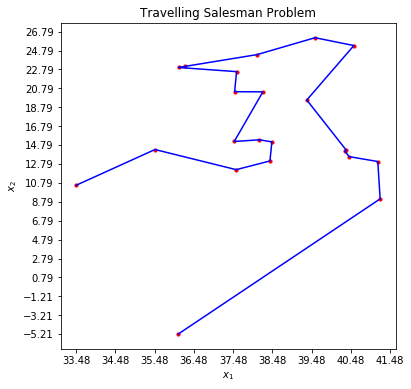

In [21]:
visualize_data(cities[best], 'best.png')


In [22]:


start_line = 6 
with open ('eil51.tsp') as f:
    lines = []
    for line in islice(f, start_line, 57):
        _, x1, x2 = line.split()
        lines.append([x1,x2])
    cities = np.asarray(lines,dtype=np.float32) 


